# Avoiding imputation undesired data entries

To avoid imputing certain missing datapoints, construct a `do_not_impute_matrix`(DNI matrix) of the same size and shape as the original dataset. For this matrix, use 0 to represent values in the original dataset that are missing and viable for imputation or non-missing. Use 1 to represent values in the original dataset that are missing but not viable for imputation (for example, measurements at timepoints occuring after death). To use the `cols_ignore` argument in `run_cissvae` or `ClusterDataset()`, make sure that the `do_not_impute_matrix` has the same column names/indices as the original dataset. 

## Example using included dataset

First load the dataset and load or create the DNI matrix. Here we can see that [1, Y12], [1, Y22], and [1, Y52] are marked as non-imputable. 


In [ ]:
import pandas as pd
from ciss_vae.data import load_example_dataset, load_dni
import ciss_vae
print(ciss_vae.__file__)

df_missing, _, clusters = load_example_dataset()

dni = load_dni()

dni.columns = df_missing.columns

print(f"Df missing:\n{df_missing.head(3).drop(df_missing.columns[:5].to_list(), axis=1)}, \n\nDo not impute:\n{dni.head(3).drop(df_missing.columns[:5].to_list(), axis=1)}")

/home/nfs/vaithid1/CISS-VAE/CISS-VAE/src/ciss_vae/__init__.py
Df missing:
        Y11  Y12        Y13        Y14        Y15        Y21  Y22        Y23  \
0 -4.049537  NaN        NaN -14.369151 -17.564448        NaN  NaN -35.772630   
1  0.546168  NaN -12.189518  -7.722474        NaN  -7.470250  NaN -25.924360   
2       NaN  NaN -20.358905 -15.126494 -17.251376 -18.448422  NaN -34.400862   

         Y24        Y25  ...       Y41  Y42       Y43       Y44       Y45  \
0 -28.098906 -30.242588  ... -0.904960  NaN       NaN -3.694852 -5.680293   
1 -17.231424 -18.695290  ...  2.624586  NaN -5.776195 -1.379495 -2.329604   
2 -27.250598 -28.839809  ...       NaN  NaN -7.215718 -3.350797 -6.895340   

        Y51  Y52       Y53       Y54       Y55  
0  2.587588  NaN -4.681195 -2.248406 -2.679081  
1  6.080512  NaN -2.290062 -0.887398  0.562532  
2  2.531148  NaN -5.427430 -1.330163 -2.324382  

[3 rows x 25 columns], 

Do not impute:
   Y11  Y12  Y13  Y14  Y15  Y21  Y22  Y23  Y24  Y25  ...  Y

## Using `run_cissvae()` with DNI matrix

The `run_cissvae()` function can accept the DNI matrix as an input. Make sure that the column names of the DNI matrix match those of the original dataset. 

In [ ]:
from ciss_vae.utils.run_cissvae import run_cissvae
from ciss_vae.utils.helpers import plot_vae_architecture

imputed_data, vae, history = run_cissvae(data = df_missing,
## Dataset params
    columns_ignore = df_missing.columns[:5], ## columns to ignore when selecting validation dataset (and clustering if you do not provide clusters). For example, demographic columns with no missingness.
    do_not_impute_matrix=dni,
    clusters = clusters,
    print_dataset = False,
    
## VAE model params
    hidden_dims = [150, 120, 60], ## Dimensions of hidden layers, in order. One number per layer. 
    latent_dim = 15, ## Dimensions of latent embedding
    layer_order_enc = ["unshared", "unshared", "unshared"], ## order of shared vs unshared layers for encode (can use u or s instead of unshared, shared)
    layer_order_dec=["shared", "shared",  "shared"],  ## order of shared vs unshared layers for decode
    latent_shared=False, 
    output_shared=False, 
    batch_size = 4000, ## batch size for data loader
    return_model = True, ## if true, outputs imputed dataset and model, otherwise just outputs imputed dataset. Set to true to return model for `plot_vae_architecture`

## Initial Training params
    epochs = 500, ## default 

## Other params
    return_history = True, ## if true, will return training MSE history as pandas dataframe
)

print(f"The successfully imputed dataset:\n{imputed_data.head}\n\n")

Cluster dataset:
 ClusterDataset(n_samples=8000, n_features=30, n_clusters=4)
  • Original missing: 61800 / 200000 (30.90%)
  • Validation held-out: 13783 (9.97% of non-missing)
  • .data shape:     (8000, 30)
  • .masks shape:    (8000, 30)
  • .val_data shape: (8000, 30)
Imputed dataset:
         Age    Salary  ZipCode10001  ZipCode20002  ZipCode30003       Y11  \
0  11.044449  6.366204           0.0           1.0           0.0 -4.049537   
1   9.727260  5.912558           1.0           0.0           0.0  0.546168   
2  11.383020  6.636472           0.0           1.0           0.0 -2.854717   

         Y12        Y13        Y14        Y15  ...       Y41        Y42  \
0  22.171087  42.665508 -14.369148 -17.564442  ... -0.904960  16.609396   
1        NaN -12.189518  -7.722474  63.735813  ...  2.624586  16.609396   
2  22.171087 -20.358906 -15.126494 -17.251377  ... -1.029794  16.609396   

         Y43       Y44       Y45       Y51        Y52       Y53       Y54  \
0  25.332270 -3.69

Below, we can see that [1, Y12], [1, Y22], and [1, Y52] are still NaN, even though other missing entries have been imputed. 

In [6]:
print(f"Imputed dataset:\n{imputed_data.drop(df_missing.columns[:5].to_list(), axis=1).head(3)}")

Imputed dataset:
        Y11        Y12        Y13        Y14        Y15        Y21        Y22  \
0 -4.049537  22.171087  42.665508 -14.369148 -17.564442 -12.284052  16.046831   
1  0.546168        NaN -12.189518  -7.722474  63.735813  -7.470250  16.046831   
2 -2.854717  22.171087 -20.358906 -15.126494 -17.251377 -18.448421        NaN   

         Y23        Y24        Y25  ...       Y41        Y42        Y43  \
0 -35.772629 -28.098907 -30.242592  ... -0.904960  16.609396  25.332270   
1 -25.924362 -17.231422 -18.695290  ...  2.624586  16.609396  -5.776194   
2 -34.400856 -27.250603 -28.839813  ... -1.029794  16.609396  -7.215719   

        Y44       Y45       Y51        Y52       Y53       Y54       Y55  
0 -3.694853 -5.680294  2.587588  15.977905 -4.681194 -2.248405 -2.679081  
1 -1.379496 -2.329605  6.080512        NaN -2.290060 -0.887396  0.562532  
2 -3.350798 -6.895340  2.531148  15.977905 -5.427431 -1.330164 -2.324383  

[3 rows x 25 columns]


As always, the vae architecture can be printed. 

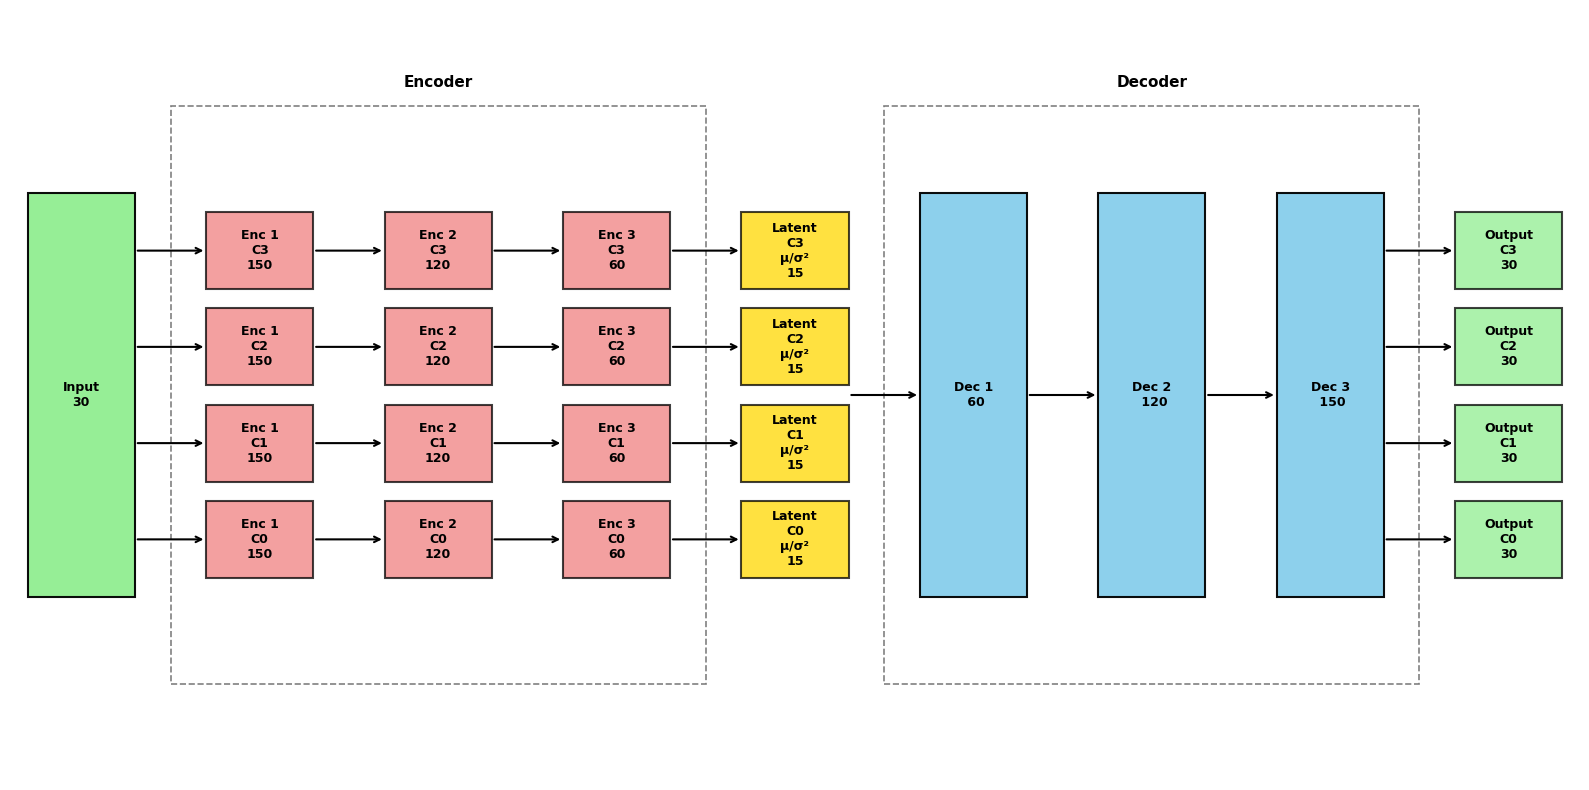

In [ ]:
plot_vae_architecture(model = vae,
                        title = None, ## Set title of plot
                        ## Colors below are default
                        color_shared = "skyblue", 
                        color_unshared ="lightcoral",
                        color_latent = "gold", # xx fix
                        color_input = "lightgreen",
                        color_output = "lightgreen",
                        figsize=(16, 8),
                        return_fig = False)